In [1]:
import numpy as np 
import tensorflow as tf

In [2]:
seq = 30
num_samples = 50000

In [3]:
def integrate(seq,num_samples ):

  for _ in range(num_samples):
  
    seq_int = np.random.uniform(-2,2, size=(seq,1))
    target = [int(np.sum(seq_int) > 0)]

    yield seq_int, target




In [ ]:
for elm in integrate(3, 20):
  print(elm)
  break

(array([[ 1.81703516],
       [ 1.84685404],
       [-1.72812374]]), [1])


creating teh dataste


In [4]:
data_gen = tf.data.Dataset.from_generator(lambda: integrate(seq, num_samples),
                                      output_types=(tf.float32,tf.float32),
                                      output_shapes=((seq, None), (None)))

In [ ]:
for elm in data: 
  print(elm)

  break

(<tf.Tensor: shape=(30, 1), dtype=float32, numpy=
array([[ 0.01414811],
       [-0.49087608],
       [ 1.4762912 ],
       [-1.1699657 ],
       [-0.31656176],
       [-0.00820046],
       [ 1.9732596 ],
       [-1.8516284 ],
       [-1.2335991 ],
       [-1.4157653 ],
       [-0.2319562 ],
       [ 0.3803576 ],
       [ 1.409033  ],
       [ 0.28683394],
       [ 0.48222715],
       [-1.8165442 ],
       [ 1.9645857 ],
       [-1.9984188 ],
       [-0.09749787],
       [-1.6334894 ],
       [ 1.4740738 ],
       [ 1.8283552 ],
       [ 1.6209981 ],
       [ 1.7909253 ],
       [-1.9488215 ],
       [ 0.5021576 ],
       [-1.4083229 ],
       [ 1.0082355 ],
       [ 1.7175624 ],
       [-0.04875762]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)


In [5]:
def pipe(value):
  value = value.shuffle(500)
  value = value.batch(5)
  value = value.prefetch(5)

  return value


data = pipe(data_gen)






In [6]:
class LSTM_Cell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LSTM_Cell, self).__init__()
        
        self.units = units
        
        self.forgate_gate = tf.keras.layers.Dense(self.units, bias_initializer='ones', activation = 'sigmoid')
        self.input_gate = tf.keras.layers.Dense(self.units, activation='sigmoid')
        self.cell_candidate = tf.keras.layers.Dense(self.units, activation='tanh')

        self.output_gate = tf.keras.layers.Dense(self.units, activation='sigmoid')

        
        
        
        
    def call(self,x, states): # lets asume state is a tuple ht-1, ct-1

      h_t0,c_t0 =states 
      x_h = tf.concat((x,h_t0), axis = 1) # axis 1 means seq size

      f = self.forgate_gate(x_h)
      i_t = self.input_gate(x_h)
      c_c = self.cell_candidate(x_h)

      c_t1 = f*c_t0
      

      it_ct = i_t * c_c 

      c_t1 = c_t1 + it_ct

      out = self.output_gate(x_h)

      h_t1 = out * tf.nn.tanh(c_t1)
      return h_t1,c_t1





In [ ]:
cell = LSTM_Cell(5)

In [ ]:
inp = tf.ones((4,1))
dem_h = tf.ones((4,5))
dem_c = tf.ones((4,5))
states = dem_h , dem_c

cell(inp,states)

(<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
 array([[0.1152489 , 0.16034305, 0.27379707, 0.42499968, 0.4829328 ],
        [0.1152489 , 0.16034305, 0.27379707, 0.42499968, 0.4829328 ],
        [0.1152489 , 0.16034305, 0.27379707, 0.42499968, 0.4829328 ],
        [0.1152489 , 0.16034305, 0.27379707, 0.42499968, 0.4829328 ]],
       dtype=float32)>, <tf.Tensor: shape=(4, 5), dtype=float32, numpy=
 array([[0.18433547, 1.1337729 , 1.3323114 , 0.79889566, 0.9420346 ],
        [0.18433547, 1.1337729 , 1.3323114 , 0.79889566, 0.9420346 ],
        [0.18433547, 1.1337729 , 1.3323114 , 0.79889566, 0.9420346 ],
        [0.18433547, 1.1337729 , 1.3323114 , 0.79889566, 0.9420346 ]],
       dtype=float32)>)

In [7]:
class LSTM_Model(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LSTM_Model, self).__init__()

        self.units = units

        self.read_in = tf.keras.layers.Dense(10, activation='sigmoid')
        
        self.cell = LSTM_Cell(units)
        

        self.read_out = tf.keras.layers.Dense(1, activation='sigmoid')
        

        
        
        
        
    def call(self,x):
      batch_size = x.shape[0]


      h_t = tf.zeros((batch_size,self.units))
      c_t = tf.zeros((batch_size,self.units))  
      states = (h_t,c_t)
      

      x = self.read_in(x)

      # passing it to teh cell and getiing the out

      for t in tf.range(x.shape[1]):

        x_t = x[:,t,:]
        states = self.cell(x_t,states)

      output = states[0]

      out = self.read_out(output)

      return out

      




      





In [ ]:
model = LSTM_Model(10)
x  = tf.ones((4,3,1))


model(x)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.49369842],
       [0.49369842],
       [0.49369842],
       [0.49369842]], dtype=float32)>

 train and test

In [8]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.round(target) == np.round(prediction)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
for elm in data.take(1):
  print(elm[0], elm[1])
  break

tf.Tensor(
[[[-0.07644245]
  [ 1.5079134 ]
  [ 1.832364  ]
  [ 0.66329074]
  [ 0.05119299]
  [-1.3096695 ]
  [ 0.02630882]
  [-1.3436368 ]
  [-0.397001  ]
  [-1.8338748 ]
  [ 1.8795983 ]
  [ 1.5409172 ]
  [ 0.585726  ]
  [ 1.8900625 ]
  [-0.68533903]
  [ 0.20730413]
  [-1.626676  ]
  [ 1.9437805 ]
  [-0.02693482]
  [-0.3513229 ]
  [-1.7979275 ]
  [-0.5728425 ]
  [-0.80165   ]
  [ 0.5983134 ]
  [ 1.1018474 ]
  [-0.23208696]
  [ 1.7538748 ]
  [-1.8766367 ]
  [ 0.26704744]
  [ 0.86261827]]

 [[ 1.2248638 ]
  [ 0.61454666]
  [ 1.2200023 ]
  [-1.3827988 ]
  [-0.7609556 ]
  [-0.11721791]
  [-0.11209115]
  [ 1.2437205 ]
  [-0.5882118 ]
  [-0.01307455]
  [-0.15588175]
  [ 1.9933455 ]
  [-0.80933636]
  [-1.4668711 ]
  [-0.94213027]
  [-1.8341511 ]
  [-1.4155077 ]
  [-0.31492075]
  [-1.8294489 ]
  [ 1.8710635 ]
  [ 0.2760023 ]
  [ 0.35581413]
  [-0.66340804]
  [ 0.29053023]
  [ 0.56975615]
  [ 0.33535302]
  [ 0.3909129 ]
  [-1.8709762 ]
  [-0.8662345 ]
  [ 1.9912055 ]]

 [[-1.1207806 ]
  [ 1.851

In [ ]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = data.take(8000)


test_dataset = data.skip(8000)

### Hyperparameters
num_epochs = 50
learning_rate = 0.001

# Initialize the model.
model = LSTM_Model(10)
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

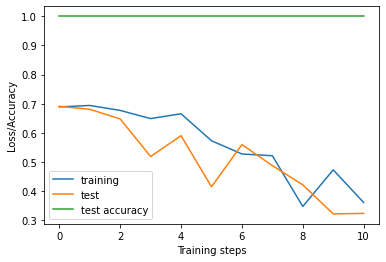

In [ ]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()